In [ ]:
# test cases
#print(gaussianRan(2))
#print(functionx(1,1))
#data = np.concatenate((x, y), axis=1)
#print(getData(3,1))
#x = np.array([[1,2], [1,3], [1,4], [1,5]])
#y = np.array([[7], [6], [5], [4]])
#w = np.array([[0.1], [0.2]])
#print(getMSE(x, y, w))

#x = np.array([[1], [2], [3]])
#d = 4
#print(polynomialx(x,d))
'''
x = np.array([[8,1,6],[3,5,7],[4,9,2]])
y = np.array([[7],[6],[5]])
w = np.array([[0.2],[0.3],[0.4]])
b = 0.1

dw, db = gradient(x,y,w,b)
print(dw)
print(db)
'''
'''
n = 50
d = 4
sigma = 0.1
Ein_avg, Eout_avg, Ebias = experiment(n, d, sigma)
print(Ein)
print(Eout)
print(Ebias)
'''

# avg (this actually isn't needed if I am normalizing from range 0 to 1)
#n_dict = {k: x/len(n_dict) for k, x in n_dict.items()}
#d_dict = {k: x/len(d_dict) for k, x in d_dict.items()}
#sigma_dict = {k: x/len(sigma_dict) for k, x in sigma_dict.items()}

#pprint(n_dict)
#pprint(d_dict)
#pprint(sigma_dict)

# normalize between 0 and 1
#y_Ein = [(y-min(y_Ein))/(max(y_Ein)-min(y_Ein)) for y in y_Ein]
#y_Eout = [(y-min(y_Eout))/(max(y_Eout)-min(y_Eout)) for y in y_Eout]
#y_Ebias = [(y-min(y_Ebias))/(max(y_Ebias)-min(y_Ebias)) for y in y_Ebias]

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn import preprocessing
torch.set_default_tensor_type('torch.DoubleTensor')

# Run Experiment
bigN = [2, 5, 10, 20, 50, 100, 200]
deg = list(range(1,21))
sigmas = [0.01, 0.1, 1]
lambd = 0
numCombinations = len(bigN)*len(deg)*len(sigmas)

In [12]:
def gaussianRan(sigma, mu=0):
    # standard normal distribution of mean 0 variance 1
    # For random samples from N(\mu, \sigma^2), use
    return sigma*np.random.randn() + mu

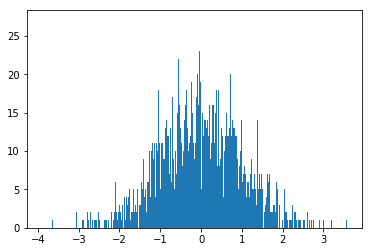

In [13]:
# test gaussian distribution
n = 10000
x = np.random.randn(n)
#x = np.random.uniform(low=0, high=1, size=(n,1))

bins = int(n/5)
plt.hist(x, bins)
plt.show()

In [14]:
def functionx(x, sigma):
    return np.cos(2*np.pi*x) + gaussianRan(sigma)

In [15]:
def getData(n, sigma):
    x = np.random.uniform(low=0, high=1, size=(n,1))
    y = functionx(x, sigma)
    return Variable(torch.from_numpy(x)), Variable(torch.from_numpy(y))

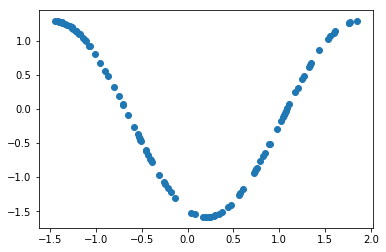

In [16]:
# graph test
n = 100
sigma = 1
x, y = getData(n, sigma)
x = preprocessing.scale(x)
y = preprocessing.scale(y)

plt.scatter(x, y)
plt.show()

In [17]:
def forwardTorchNumpy(x, y, w, lambd, is_numpy=False):
    if is_numpy:
        y_pred = np.dot(x,w)
    else:
        y_pred = torch.mm(x,w)
    return getMSE(y_pred, y, w, lambd, is_numpy=is_numpy)

In [18]:
a = torch.Tensor([[1,2],[3,4]])
print(a)
print(a.t())

tensor([[1., 2.],
        [3., 4.]])
tensor([[1., 3.],
        [2., 4.]])


In [19]:
def getMSE(y_pred, y, w, lambd, is_numpy=False):
    if is_numpy:
        return np.mean((y_pred - y)**2) + lambd*np.mean(np.dot(w.T, w))
    return torch.mean((y_pred - y)**2) + lambd*torch.mean(torch.mm(w.t(), w))

In [51]:
y_pred = torch.Tensor([[1.5],[1]])
y = torch.Tensor([[2],[2]])
w = torch.Tensor([[1],[1]])
lambd = 1
print(getMSE(y_pred, y, w, lambd))

tensor(2.6250)


In [63]:
def polynomialx(x, d, is_numpy=False):
    poly = preprocessing.PolynomialFeatures(d, include_bias=False)
    x = poly.fit_transform(x)
        
    if is_numpy is False:
        x = torch.from_numpy(x)
    return x

In [64]:
x = np.array([[2], [3], [4]])
d = 2
print(polynomialx(x,d))

tensor([[ 2.,  4.],
        [ 3.,  9.],
        [ 4., 16.]])


In [145]:
def gradApprox(lr, x, y, lambd, e=1e-7):
    w = lr.linear.weight.data.reshape(-1,1)
    dwa = torch.zeros(w.size())
    
    i = 0
    for val in w:
        wp, wm = w.copy(), w.copy()
        print(wp)
        wp[i] += e
        wm[i] -= e
        print(wp)
         
        jp = getMSE(lr.forward(x), y, wp, lambd)
        jm = getMSE(lr.forward(x), y, wm, lambd)
        print(jp)
        dwa[i] = (jp - jm)/(2*e)
        i += 1
    
    return dwa

In [141]:
def checkGrad(lr, x, y, lambd):
    dw = lr.linear.weight.grad.data.reshape(-1, 1)
    dwa = gradApprox(lr,x,y,lambd)
    dw, dwa = dw.detach().numpy(), dwa.detach().numpy()
    print(dw)
    print(dwa)
    print("*****************************************")
    e = np.linalg.norm(dw-dwa)/(np.linalg.norm(dw) + np.linalg.norm(dwa))
    print("Grad approx error: ", e)

In [65]:
class LrModule(nn.Module):

    def __init__(self, degree):
        super(LrModule, self).__init__()
        self.linear = nn.Linear(d,1)

    def forward(self, x):
        # linear
        return self.linear(x)

In [52]:
lr = LrModule(4)
print(lr.linear)

Linear(in_features=5, out_features=1, bias=True)


In [170]:
def fitData(x, y, d, sigma, lambd=0, learning_rate=1e-2, itera=50, n_test=1000, check_grad=False):  
    # create polynomial x matrix
    x = polynomialx(x, d)
    
    # keep track of cost for testing
    cost_hist = []
    it_hist = []
    
    lr = LrModule(d)
    #print(lr.linear.weight.data)
    #print(lr.linear.bias.data)
    
    for i in range(itera):
        # clear grads
        lr.zero_grad()
        
        # Forward
        y_pred = lr.forward(x)
        
        # loss
        w = lr.linear.weight.data
        cost = getMSE(y_pred, y, w, lambd)
        
        # Backward for derivative
        cost.backward()
        
        # Gradient checking
        if check_grad:
            checkGrad(lr, x, y, lambd)
            break
        
        # Update gradient
        lr.linear.weight.data -= learning_rate*lr.linear.weight.grad.data
        lr.linear.bias.data -= learning_rate*lr.linear.bias.grad.data
        
        # Save cost history for testing
        cost_hist.append(cost.detach().numpy())
        it_hist.append(i)
    
    w = lr.linear.weight.data
    
    # Calculate Ein
    Ein = getMSE(lr.forward(x), y, w, lambd)
    
    # Calculate Eout, with test dataset
    x_test, y_test = getData(n_test, sigma)
    
    # create x_test dimension d
    x_test = polynomialx(x_test, d)
    
    # Calculate
    Eout = getMSE(lr.forward(x_test), y_test, w, lambd)
    
    return Ein.detach().numpy(), Eout.detach().numpy(), lr, [it_hist, cost_hist]

tensor([[ 0.4991, -0.3734, -0.0673,  0.4381]])
tensor([0.0064])
0.034826418682712454
1.7750692802098835


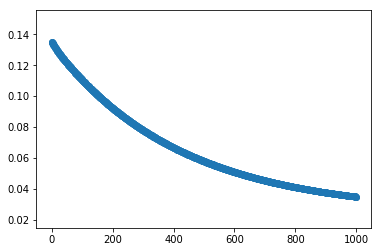

In [160]:
#x = np.array([[1],[2],[3]])
d, sigma, n, lambd = 4, 1, 5, 0
x, y = getData(n,sigma)
Ein, Eout, lr, plot_data = fitData(x, y, d, sigma, lambd=lambd, check_grad=False)

print(Ein)
print(Eout)

xx, yy = plot_data
#print(xx)
#print(yy)
plt.scatter(xx, yy)
plt.show()

In [173]:
def experiment(n, d, sigma, lambd, trials=5, n_test=2000):
    # initialize
    Ein_hist, Eout_hist = np.array([]), np.array([])
    w_hist, b_hist = np.empty([d, 0]), np.array([])
    
    for trail in range(trials):
        x, y = getData(n, sigma)
        Ein, Eout, lr, plot_data = fitData(x, y, d, sigma)
        Ein_hist = np.append(Ein_hist, [Ein])
        Eout_hist = np.append(Eout_hist, [Eout])
        w_hist = np.append(w_hist, lr.linear.weight.data.detach().numpy().reshape(-1,1), axis=1)
        b_hist = np.append(b_hist, lr.linear.bias.data.detach().numpy().reshape(-1,1))
    
    print(Ein_hist)
    print(Eout_hist)
    print(w_hist)
    print(b_hist)
    
    # take the avg
    Ein_avg = np.mean(Ein_hist)
    Eout_avg = np.mean(Eout_hist)
    w_avg = (1/trials)*np.sum(w_hist, axis=1).reshape(d,1)
    b_avg = np.mean(b_hist)
    
    print(Ein_avg)
    print(Eout_avg)
    print(w_avg)
    print(b_avg)
    
    # Test dataset on averaged polynomials
    x_test, y_test = getData(n_test, sigma)
    
    # create x_test dimension d
    x_test = polynomialx(x_test, d)

    lr.linear.weight.data = torch.from_numpy(w_avg)
    lr.bias.weight.data = torch.from_numpy(b_avg)
    Ebias = getMSE(lr.forward(x_test), y_test, w_avg, lambd)
    
    return Ein_avg, Eout_avg, Ebias

In [174]:
# testing
#bigN = [50]
#deg = [4]
#sigmas = [0.1]

experiments = []

cntCombinations = 0
print("Number combinations: ", numCombinations)

for n in bigN:
    for d in deg:
        for sigma in sigmas:
            cntCombinations+=1
            Ein_avg, Eout_avg, Ebias = experiment(n, d, sigma, lambd)
            
            print("Experiment ", cntCombinations)
            print("Inputs N, d, sigma: %s, %s, %s" % (n, d, sigma))
            print("%s, %s, %s" % (Ein_avg, Eout_avg, Ebias))
            experiments.append([n, d, sigma, Ein_avg, Eout_avg, Ebias])
            break

# save experiment
with open("experiments_6", 'w', encoding="utf-8") as fout:
    pprint(experiments, fout)


Number combinations:  420
[0.48287531 0.87703284 0.01481566 0.58844806 0.09059348]
[0.55428907 0.55313568 0.81564727 0.55481854 1.28045069]
[[ 0.65389994  0.1200675  -0.79758317  0.57601446  0.50074794]]
[-0.17072111  0.1866696   0.91404756 -0.45492934  0.66123439]
0.4107530702041607
0.7516682501379975
[[0.21062933]]
0.22726022087198658


TypeError: expected np.ndarray (got numpy.float64)

{2: array([0.45837415, 0.90384567, 1.16393596]),
 5: array([0.54814239, 0.91733238, 0.94395157]),
 10: array([0.57312363, 0.84563864, 0.69152615]),
 20: array([0.60487606, 0.85937543, 0.74498963]),
 50: array([0.61324284, 0.85215474, 0.93351591]),
 100: array([0.61681147, 0.83650011, 0.70172925]),
 200: array([0.6203054 , 0.84424502, 0.84310786])}
{1: array([0.62417405, 0.87273296, 0.92797748]),
 2: array([0.59369231, 0.86520665, 0.63646193]),
 3: array([0.57964491, 0.86644787, 1.19898827]),
 4: array([0.60645446, 0.86182971, 0.62190911]),
 5: array([0.58650851, 0.91957959, 0.66671218]),
 6: array([0.58796663, 0.88648265, 0.94686135]),
 7: array([0.56851025, 0.84160771, 0.62291448]),
 8: array([0.57565344, 0.86125861, 1.41328062]),
 9: array([0.58116179, 0.87033567, 0.67646186]),
 10: array([0.59559547, 0.88558937, 1.08572869]),
 11: array([0.57449159, 0.84452827, 1.08092596]),
 12: array([0.55887955, 0.89647923, 1.1814942 ]),
 13: array([0.57639729, 0.89878266, 0.91056736]),
 14: arra

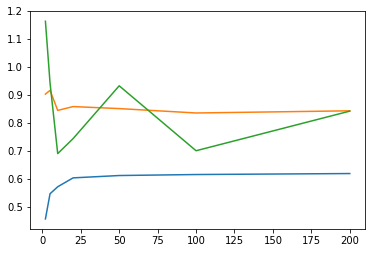

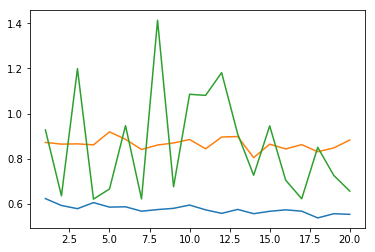

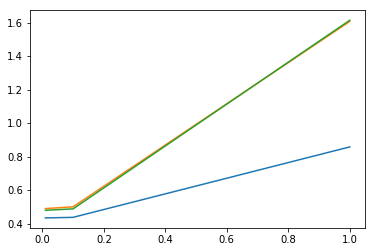

In [150]:
# do fun stuff with experiment
with open("experiments_4", "r", encoding='utf-8') as f:
    experiments = eval(f.read())
    
n_dict, d_dict, sigma_dict = dict(), dict(), dict()
for exp in experiments:
    n, d, s = exp[0], exp[1], exp[2]
    
    n_dict[n] = n_dict.get(n, np.array([0, 0, 0])) + np.array(exp[3:6])
    d_dict[d] = d_dict.get(d, np.array([0, 0, 0])) + np.array(exp[3:6])
    sigma_dict[s] = sigma_dict.get(s, np.array([0, 0, 0])) + np.array(exp[3:6])

# avg (this actually isn't needed if I am normalizing from range 0 to 1)
n_dict = {k: x/(numCombinations/len(n_dict)) for k, x in n_dict.items()}
d_dict = {k: x/(numCombinations/len(d_dict)) for k, x in d_dict.items()}
sigma_dict = {k: x/(numCombinations/len(sigma_dict)) for k, x in sigma_dict.items()}

pprint(n_dict)
pprint(d_dict)
pprint(sigma_dict)

# plot n vs Ein_avg, Eout_avg, Ebias
y_Ein = [n_dict[n][0] for n in bigN]
y_Eout = [n_dict[n][1] for n in bigN]
y_Ebias = [n_dict[n][2] for n in bigN]

plt.plot(bigN, y_Ein)
plt.plot(bigN, y_Eout)
plt.plot(bigN, y_Ebias)
plt.show()

# plot deg vs Ein_avg, Eout_avg, Ebias
y_Ein = [d_dict[n][0] for n in deg]
y_Eout = [d_dict[n][1] for n in deg]
y_Ebias = [d_dict[n][2] for n in deg]

plt.plot(deg, y_Ein)
plt.plot(deg, y_Eout)
plt.plot(deg, y_Ebias)
plt.show()

# plot sigma vs Ein_avg, Eout_avg, Ebias
y_Ein = [sigma_dict[n][0] for n in sigmas]
y_Eout = [sigma_dict[n][1] for n in sigmas]
y_Ebias = [sigma_dict[n][2] for n in sigmas]

plt.plot(sigmas, y_Ein)
plt.plot(sigmas, y_Eout)
plt.plot(sigmas, y_Ebias)
plt.show()